### Server CPU% Forecasting Challenge

#### Objectifs :
        - Perform Exploratory Data Analysis (EDA) on 30-minute CPU telemetry data
        - Build a time series forecasting model to predict the next 14 days (672 half-hour intervals)
        - Evaluate model performance using RMSE, MAE, and R²
        - Export predictions and visualize Actual vs Forecast in Power BI

##### Let's first start with cleaning the data and generating plots

In [2]:

! pip install pandas numpy matplotlib statsmodels seaborn scikit-learn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib  # or use import pickle

df = pd.read_csv("Challenge_CPU_prediction/Data/cpu_usage.csv")

df['Date'] = pd.to_datetime(df['Date'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['service_description'] = df['service_description'].astype("string")
df.set_index('Timestamp', inplace=True)


#print(df.dtypes)

/var/folders/5h/zq5wwpvd123278t5ckn5zdn80000gn/T/ipykernel_1467/255849822.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])
/var/folders/5h/zq5wwpvd123278t5ckn5zdn80000gn/T/ipykernel_1467/255849822.py:12: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


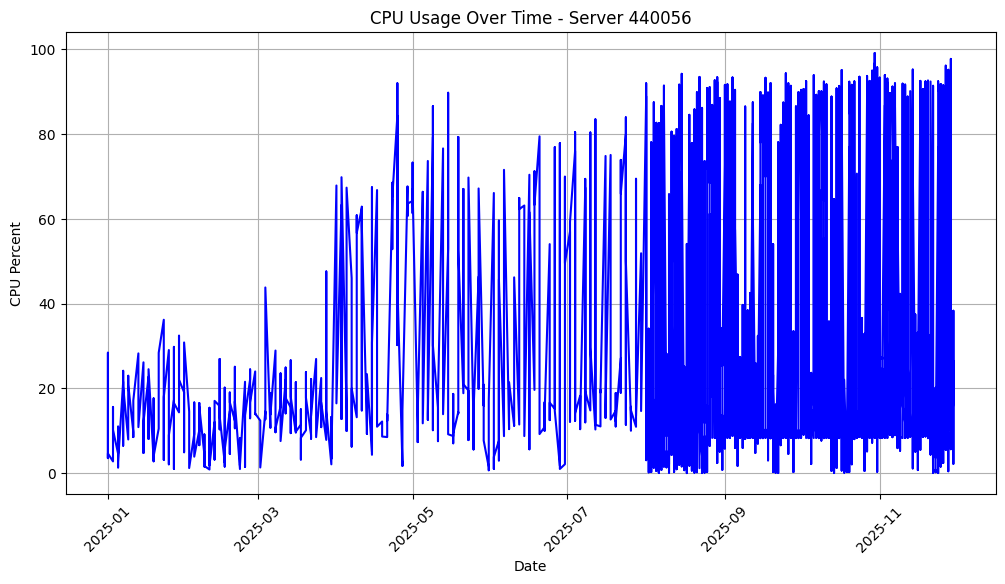

In [4]:
serverID = 440056
server_data = df[df['server_id'] == serverID].sort_values('Date')

plt.figure(figsize=(12,6))
plt.plot(server_data['Date'], server_data['CPU_percent'], color='blue')  # simple line
plt.title(f"CPU Usage Over Time - Server {serverID}")
plt.xlabel('Date')
plt.ylabel('CPU Percent')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

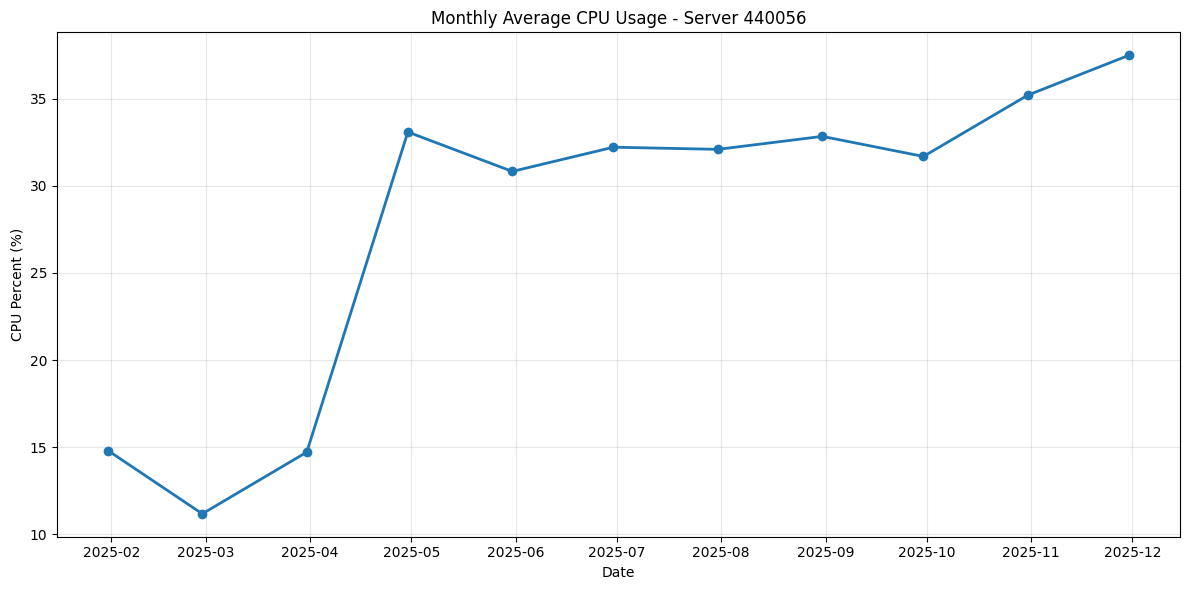

In [5]:
serverID = 440056

server_data = df[df['server_id'] == serverID].copy()

server_data['Date'] = pd.to_datetime(server_data['Date'])
server_data.set_index('Date', inplace=True)

server_data = server_data.sort_index()

monthly_cpu = server_data['CPU_percent'].resample('M').mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_cpu.index, monthly_cpu.values, marker='o', linewidth=2)
plt.title(f"Monthly Average CPU Usage - Server {serverID}")
plt.xlabel("Date")
plt.ylabel("CPU Percent (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

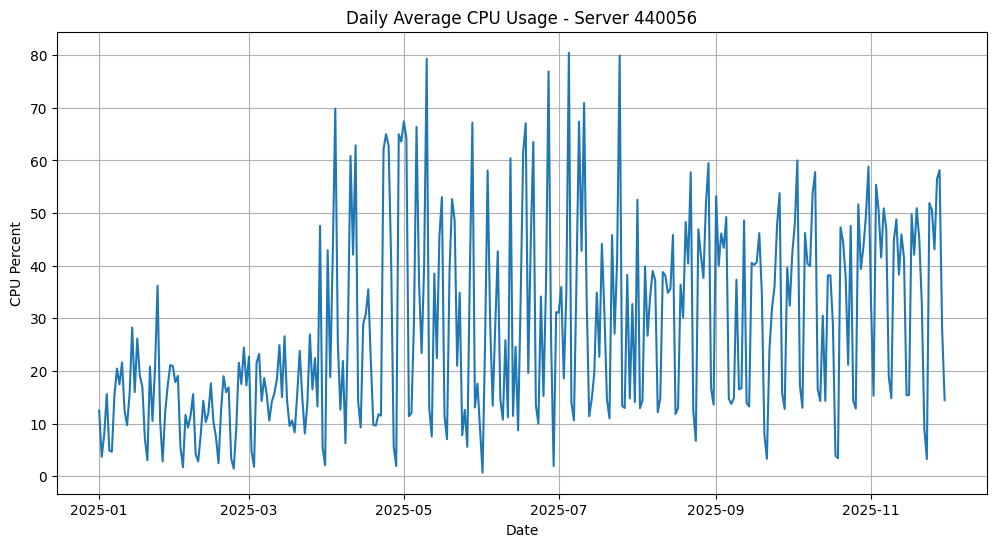

In [6]:
serverID = 440056
server_data = df[df['server_id'] == serverID].sort_values('Date')

daily_cpu = server_data['CPU_percent'].resample('D').mean()

plt.figure(figsize=(12,6))
plt.plot(daily_cpu.index, daily_cpu.values)
plt.title(f"Daily Average CPU Usage - Server {serverID}")
plt.xlabel("Date")
plt.ylabel("CPU Percent")
plt.grid(True)
plt.show()

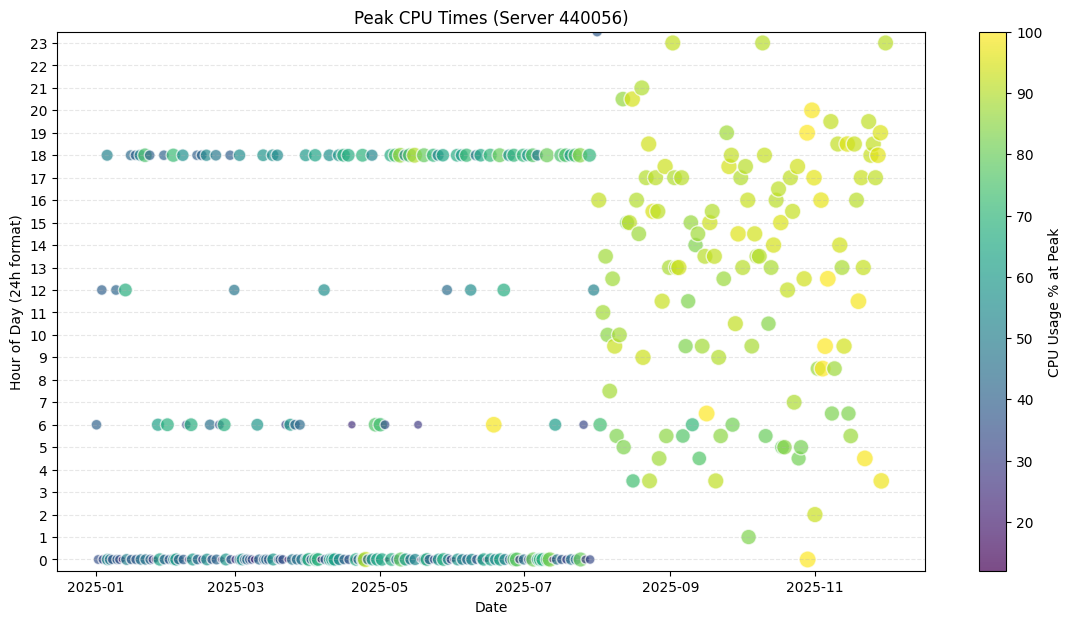

In [7]:
df_temp = pd.read_csv("Challenge_CPU_prediction/Data/cpu_usage.csv")

time_col = 'Timestamp'
#print(f"Using column: {time_col}")

# 1. Convert the identified column to datetime
df_temp[time_col] = pd.to_datetime(df_temp[time_col], dayfirst=True)

# 2. Find the peak for each day using the correct column name
peak_indices = df_temp.groupby(df_temp[time_col].dt.date)['CPU_percent'].idxmax()
daily_peaks = df_temp.loc[peak_indices].copy()

# 3. Create the Y-axis float (Hour + Minute/60)
daily_peaks['Peak_Hour_Float'] = daily_peaks[time_col].dt.hour + (daily_peaks[time_col].dt.minute / 60)

# --- Visualization ---
plt.figure(figsize=(14, 7))

scatter = plt.scatter(
    daily_peaks[time_col],
    daily_peaks['Peak_Hour_Float'],
    c=daily_peaks['CPU_percent'],
    s=daily_peaks['CPU_percent'] * 1.5,
    cmap='viridis',
    alpha=0.7,
    edgecolors='white'
)

# Formatting
plt.yticks(range(0, 24))
plt.ylim(-0.5, 23.5)
plt.colorbar(scatter, label='CPU Usage % at Peak')

plt.title(f'Peak CPU Times (Server {serverID})')
plt.xlabel('Date')
plt.ylabel('Hour of Day (24h format)')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.show()

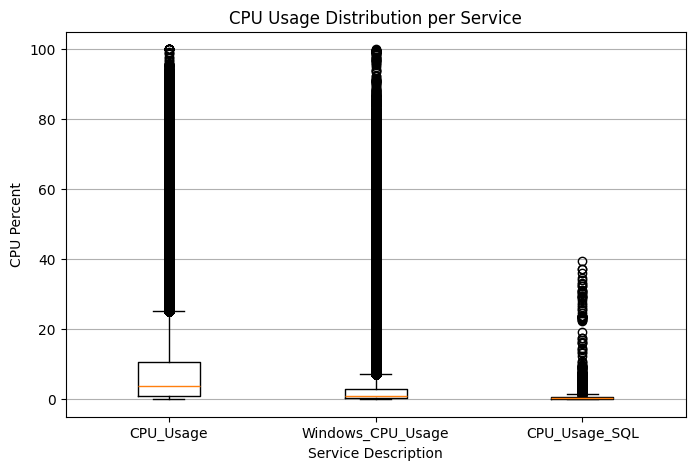

In [8]:
plt.figure(figsize=(8,5))

# Group CPU values by service_description
groups = [
    df[df['service_description'] == service]['CPU_percent']
    for service in df['service_description'].unique()
]

plt.boxplot(groups, labels=df['service_description'].unique())

plt.title('CPU Usage Distribution per Service')
plt.xlabel('Service Description')
plt.ylabel('CPU Percent')
plt.grid(axis='y')

plt.show()

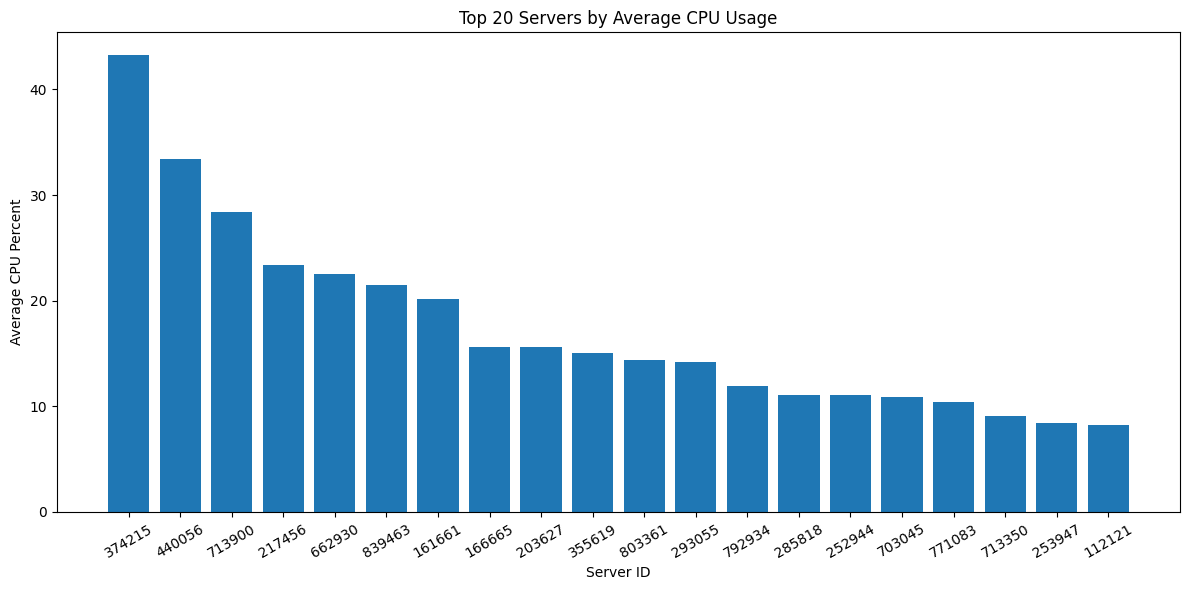

In [9]:
top_n = 20  # adjust as needed

avg_cpu = (
    df.groupby('server_id')['CPU_percent']
      .mean()
      .sort_values(ascending=False)
      .head(top_n)
)

plt.figure(figsize=(12,6))
plt.bar(avg_cpu.index.astype(str), avg_cpu.values)
plt.title(f'Top {top_n} Servers by Average CPU Usage')
plt.xlabel('Server ID')
plt.ylabel('Average CPU Percent')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


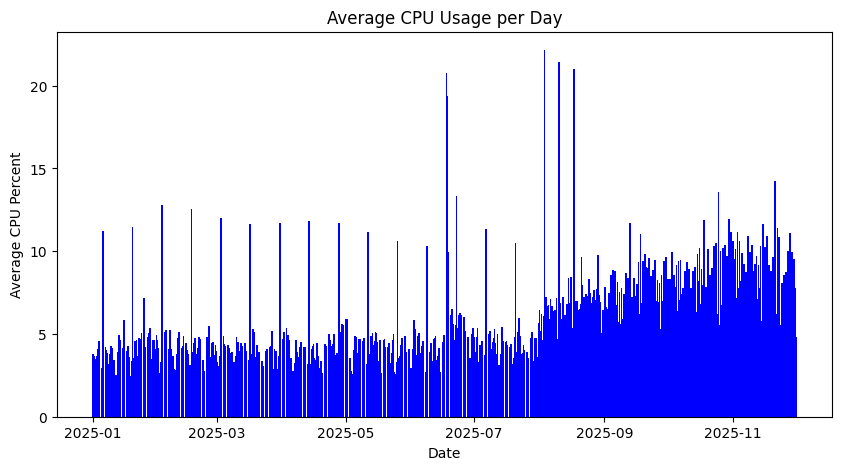

In [10]:
avg_cpu = df.groupby('Timestamp')['CPU_percent'].mean().sort_values()
plt.figure(figsize=(10,5))
plt.bar(avg_cpu.index, avg_cpu.values, color='blue')
plt.title('Average CPU Usage per Day')
plt.xlabel('Date')
plt.ylabel('Average CPU Percent')
plt.show()

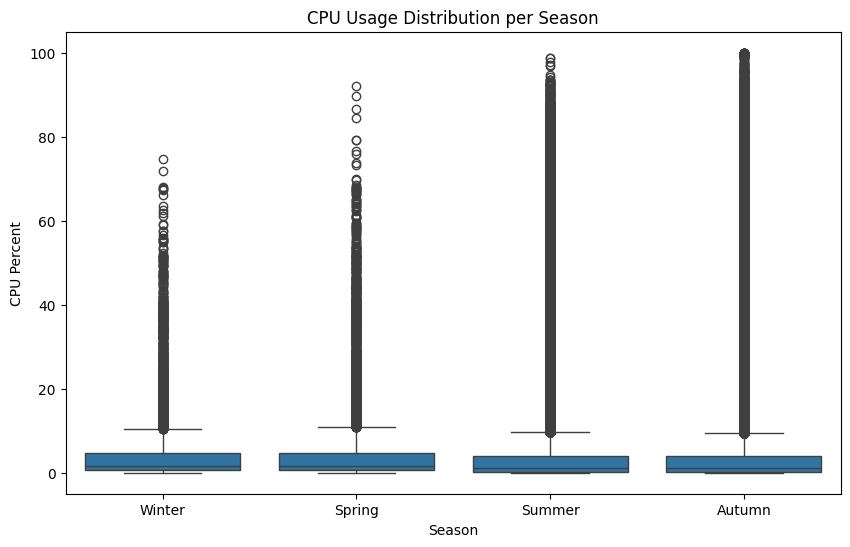

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

# Function to map month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Create season column
df['Season'] = df['Date'].dt.month.apply(month_to_season)

plt.figure(figsize=(10,6))
sns.boxplot(x='Season', y='CPU_percent', data=df, order=['Winter','Spring','Summer','Autumn'])
plt.title('CPU Usage Distribution per Season')
plt.xlabel('Season')
plt.ylabel('CPU Percent')
plt.show()

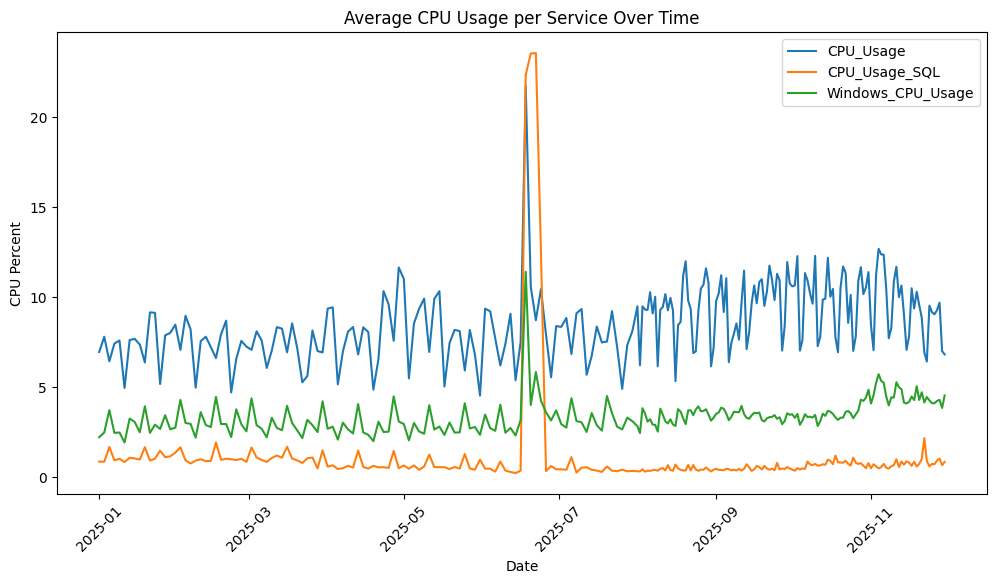

In [12]:
plt.figure(figsize=(12,6))

# Aggregate CPU percent per service per date
agg_df = df.groupby(['Date', 'service_description'])['CPU_percent'].mean().reset_index()

services = agg_df['service_description'].unique()
for service in services:
    svc_data = agg_df[agg_df['service_description'] == service]
    plt.plot(svc_data['Date'], svc_data['CPU_percent'], label=service)

plt.legend()
plt.title('Average CPU Usage per Service Over Time')
plt.xlabel('Date')
plt.ylabel('CPU Percent')
plt.xticks(rotation=45)
plt.show()


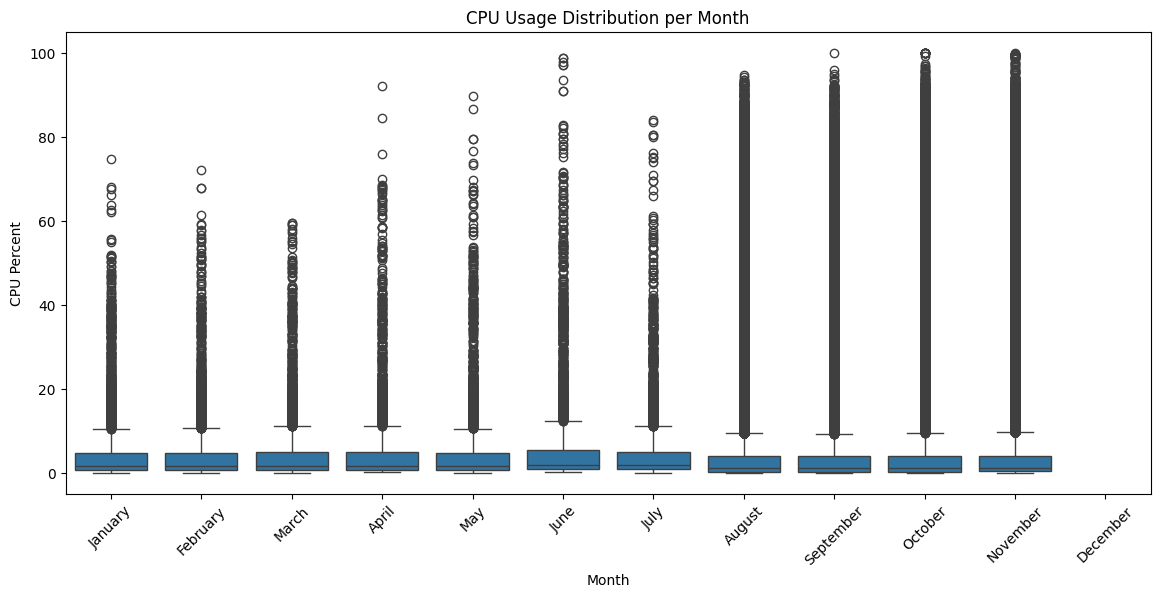

In [13]:
df['Month'] = df['Date'].dt.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(14,6))
sns.boxplot(x='Month', y='CPU_percent', data=df, order=month_order)
plt.title('CPU Usage Distribution per Month')
plt.xlabel('Month')
plt.ylabel('CPU Percent')
plt.xticks(rotation=45)
plt.show()

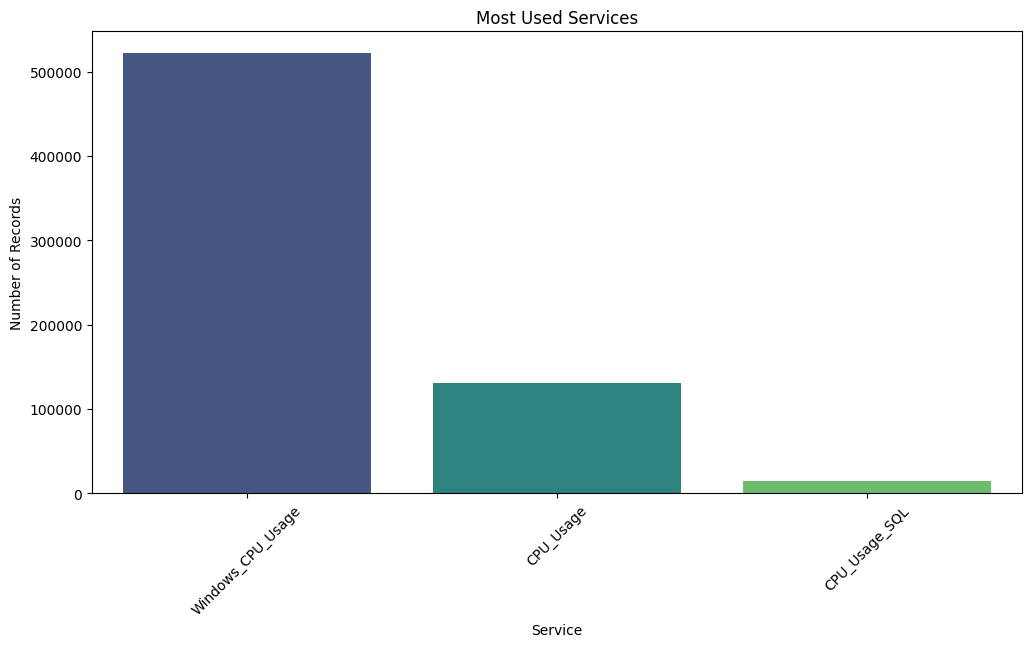

In [14]:
service_counts = df['service_description'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=service_counts.index, y=service_counts.values, palette='viridis')
plt.title('Most Used Services')
plt.xlabel('Service')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.show()

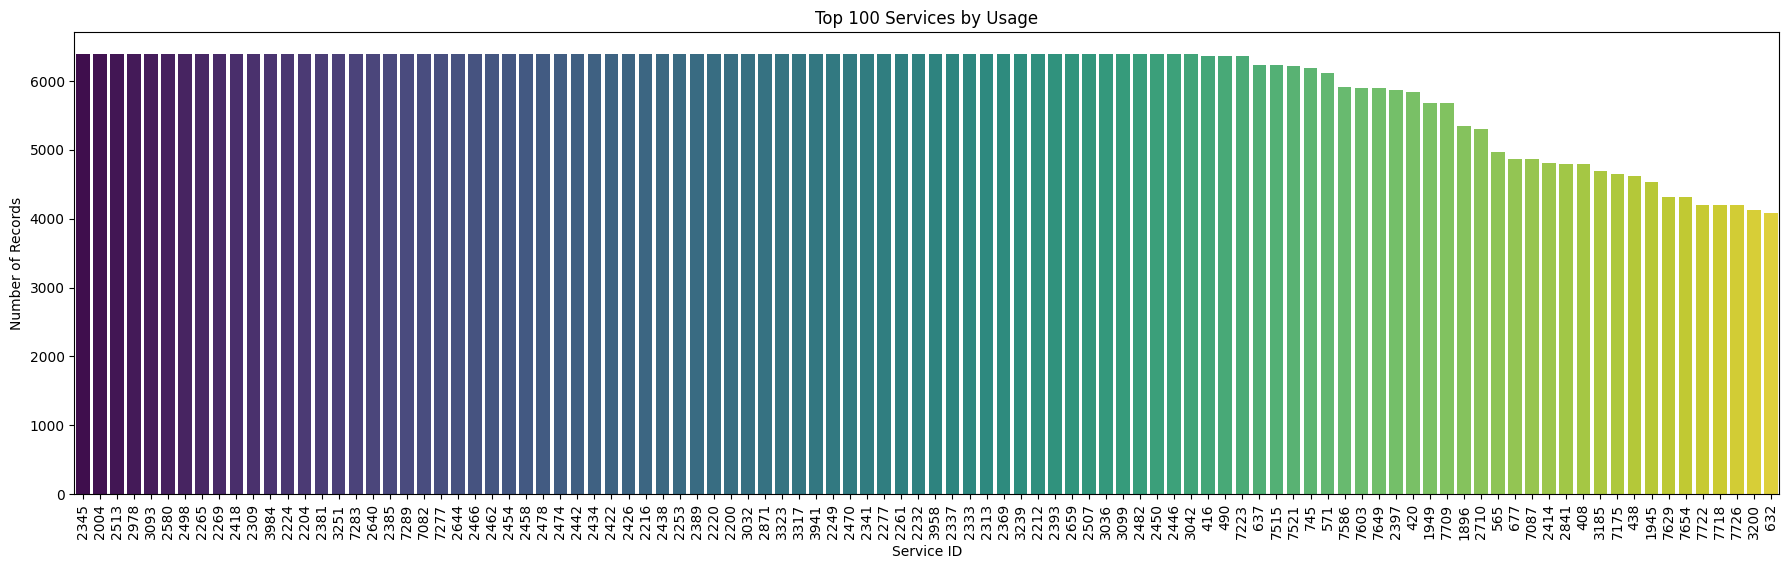

In [15]:
service_counts = df['service_id'].value_counts()
top_services = service_counts.head(100)

plt.figure(figsize=(22,6))
sns.barplot(
    x=top_services.index,
    y=top_services.values,
    palette='viridis',
    order=top_services.index
)
plt.title('Top 100 Services by Usage')
plt.xlabel('Service ID')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)
plt.show()

In [16]:

df = pd.read_csv("Challenge_CPU_prediction/Data/cpu_usage.csv", parse_dates=['Timestamp'])

df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

resampled_list = []

# Process each server separately
for server_id, group in df.groupby('server_id'):
    # Resample at 30-min intervals (keeps all columns)
    group_resampled = group.resample('30min').asfreq()

    # Interpolate numeric columns (like CPU_percent)
    numeric_cols = group_resampled.select_dtypes(include='number').columns
    group_resampled[numeric_cols] = group_resampled[numeric_cols].interpolate(method='linear')

    # Fill non-numeric columns forward (except server_id and service_id)
    for col in group_resampled.columns:
        if col not in ['server_id', 'service_id'] and group_resampled[col].dtype == 'object':
            group_resampled[col] = group_resampled[col].ffill()

    # Reset index to make Timestamp a column
    group_resampled = group_resampled.reset_index()

    # Ensure server_id and service_id are integers
    group_resampled['server_id'] = group_resampled['server_id'].astype(int)
    group_resampled['service_id'] = group_resampled['service_id'].astype(int)

    # Append to list
    resampled_list.append(group_resampled)

# Concatenate all servers
df_30min_per_server = pd.concat(resampled_list, ignore_index=True)
df_30min_per_server = df_30min_per_server.drop(columns=['Date'])

print(df_30min_per_server.head(20))

             Timestamp  server_id  service_id service_description  CPU_percent
0  2025-01-01 00:00:00     100595         490           CPU_Usage     8.867491
1  2025-01-01 00:30:00     100595         490           CPU_Usage     8.508133
2  2025-01-01 01:00:00     100595         490           CPU_Usage     8.148776
3  2025-01-01 01:30:00     100595         490           CPU_Usage     7.789419
4  2025-01-01 02:00:00     100595         490           CPU_Usage     7.430062
5  2025-01-01 02:30:00     100595         490           CPU_Usage     7.070704
6  2025-01-01 03:00:00     100595         490           CPU_Usage     6.711347
7  2025-01-01 03:30:00     100595         490           CPU_Usage     6.351990
8  2025-01-01 04:00:00     100595         490           CPU_Usage     5.992633
9  2025-01-01 04:30:00     100595         490           CPU_Usage     5.633275
10 2025-01-01 05:00:00     100595         490           CPU_Usage     5.273918
11 2025-01-01 05:30:00     100595         490       

In [19]:
!pip install optuna xgboost scikit-learn pandas numpy

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna
import warnings
warnings.filterwarnings('ignore')

# ====== CRITICAL FIX: IMPROVED FEATURE ENGINEERING ======
def create_advanced_features(df, lags=[1, 2, 3, 4, 5, 6, 12, 24, 48]):
    """
    Create comprehensive time series features
    """
    features_df = df.copy()

    # 1. Basic lag features
    for lag in lags:
        features_df[f'lag_{lag}'] = features_df.groupby('server_id')['CPU_percent'].shift(lag)

    # 2. Rolling statistics (window features)
    windows = [2, 6, 12, 24, 48]
    for window in windows:
        features_df[f'rolling_mean_{window}'] = features_df.groupby('server_id')['CPU_percent'].shift(1).rolling(window=window, min_periods=1).mean()
        features_df[f'rolling_std_{window}'] = features_df.groupby('server_id')['CPU_percent'].shift(1).rolling(window=window, min_periods=1).std()
        features_df[f'rolling_min_{window}'] = features_df.groupby('server_id')['CPU_percent'].shift(1).rolling(window=window, min_periods=1).min()
        features_df[f'rolling_max_{window}'] = features_df.groupby('server_id')['CPU_percent'].shift(1).rolling(window=window, min_periods=1).max()

    # 3. Time-based features with cyclical encoding
    features_df['hour'] = features_df['Timestamp'].dt.hour
    features_df['day_of_week'] = features_df['Timestamp'].dt.dayofweek
    features_df['day_of_month'] = features_df['Timestamp'].dt.day
    features_df['month'] = features_df['Timestamp'].dt.month
    features_df['week_of_year'] = features_df['Timestamp'].dt.isocalendar().week

    # 4. Cyclical encoding for hour and day (important for time series!)
    features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
    features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)
    features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
    features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)

    # 5. Statistical features from recent history
    features_df['recent_mean_6'] = features_df.groupby('server_id')['CPU_percent'].shift(1).rolling(window=6, min_periods=1).mean()
    features_df['recent_std_6'] = features_df.groupby('server_id')['CPU_percent'].shift(1).rolling(window=6, min_periods=1).std()

    # 6. Difference features
    features_df['diff_1'] = features_df.groupby('server_id')['CPU_percent'].diff(1)
    features_df['diff_24'] = features_df.groupby('server_id')['CPU_percent'].diff(24)  # 12 hours for 30-min data

    # 7. Is it business hours? (9 AM to 5 PM)
    features_df['is_business_hours'] = ((features_df['hour'] >= 9) & (features_df['hour'] <= 17)).astype(int)

    # 8. Is it nighttime? (12 AM to 6 AM)
    features_df['is_night'] = ((features_df['hour'] >= 0) & (features_df['hour'] <= 6)).astype(int)

    # 9. Weekend flag
    features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)

    # Drop rows with NaN values created by lag/rolling operations
    features_df = features_df.dropna()

    return features_df

# ====== FIXED OPTIMIZATION FUNCTION (XGBoost version compatible) ======
def optimize_and_train_server_improved(df_server, n_trials=50):
    """
    Improved training with better validation and early stopping
    """
    # Feature columns (exclude non-feature columns)
    exclude_cols = ['Timestamp', 'CPU_percent', 'server_id', 'service_description']
    feature_cols = [col for col in df_server.columns if col not in exclude_cols]

    X = df_server[feature_cols]
    y = df_server['CPU_percent']

    # IMPORTANT: Time-based split (not random)
    split_idx = int(len(df_server) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Scale features (important for time series)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'random_state': 42,
            'n_jobs': -1,
            'eval_metric': 'rmse'  # FIXED: Add eval_metric to constructor
        }

        # FIXED: Create model with eval_metric in constructor
        model = XGBRegressor(**params)

        # Use TimeSeriesSplit for validation
        tscv = TimeSeriesSplit(n_splits=3)
        rmse_scores = []

        for train_idx, val_idx in tscv.split(X_train_scaled):
            X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # FIXED: Remove eval_metric from fit() call
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=20,
                verbose=False
            )

            y_pred = model.predict(X_val)
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

        return np.mean(rmse_scores)

    # Run optimization
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_params = study.best_params

    # Add eval_metric to best_params
    best_params['eval_metric'] = 'rmse'
    best_params['random_state'] = 42
    best_params['n_jobs'] = -1

    # Train final model with best params
    final_model = XGBRegressor(**best_params)

    # Fit with early stopping on validation split
    val_size = int(len(X_train_scaled) * 0.2)
    X_train_final, X_val_final = X_train_scaled[:-val_size], X_train_scaled[-val_size:]
    y_train_final, y_val_final = y_train.iloc[:-val_size], y_train.iloc[-val_size:]

    # FIXED: Remove eval_metric from fit() call
    final_model.fit(
        X_train_final, y_train_final,
        eval_set=[(X_val_final, y_val_final)],
        early_stopping_rounds=20,
        verbose=False
    )

    # Predict on test set
    y_pred = final_model.predict(X_test_scaled)

    # Calculate metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'MAPE': np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-8, None))) * 100
    }

    # Prepare predictions
    predictions = pd.DataFrame({
        'server_id': df_server.loc[X_test.index, 'server_id'].values,
        'Timestamp': df_server.loc[X_test.index, 'Timestamp'].values,
        'CPU_actual': y_test.values,
        'CPU_pred': y_pred
    })

    return final_model, predictions, metrics, scaler

# ====== FIXED SIMPLE MODEL (XGBoost version compatible) ======
def train_simple_xgboost(df_server):
    """
    Simplified model with reasonable defaults for servers with limited data
    """
    exclude_cols = ['Timestamp', 'CPU_percent', 'server_id', 'service_description']
    feature_cols = [col for col in df_server.columns if col not in exclude_cols]

    X = df_server[feature_cols]
    y = df_server['CPU_percent']

    # Time-based split
    split_idx = int(len(df_server) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # FIXED: Add eval_metric to constructor
    model = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=1,
        random_state=42,
        n_jobs=-1,
        eval_metric='rmse'  # FIXED: Add eval_metric to constructor
    )

    # Train with early stopping
    val_size = int(len(X_train_scaled) * 0.2)
    X_train_final, X_val_final = X_train_scaled[:-val_size], X_train_scaled[-val_size:]
    y_train_final, y_val_final = y_train.iloc[:-val_size], y_train.iloc[-val_size:]

    # FIXED: Remove eval_metric from fit() call
    model.fit(
        X_train_final, y_train_final,
        eval_set=[(X_val_final, y_val_final)],
        early_stopping_rounds=20,
        verbose=False
    )

    # Predict
    y_pred = model.predict(X_test_scaled)

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'MAPE': np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-8, None))) * 100
    }

    predictions = pd.DataFrame({
        'server_id': df_server.loc[X_test.index, 'server_id'].values,
        'Timestamp': df_server.loc[X_test.index, 'Timestamp'].values,
        'CPU_actual': y_test.values,
        'CPU_pred': y_pred
    })

    return model, predictions, metrics, scaler

# ====== ALTERNATIVE: SIMPLER BUT ROBUST APPROACH ======
def train_robust_model(df_server):
    """
    Even simpler approach that's guaranteed to work
    """
    exclude_cols = ['Timestamp', 'CPU_percent', 'server_id', 'service_description']
    feature_cols = [col for col in df_server.columns if col not in exclude_cols]

    X = df_server[feature_cols]
    y = df_server['CPU_percent']

    # Time-based split
    split_idx = int(len(df_server) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Use simpler model without early stopping if needed
    model = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    # Simple fit without validation
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

    predictions = pd.DataFrame({
        'server_id': df_server.loc[X_test.index, 'server_id'].values,
        'Timestamp': df_server.loc[X_test.index, 'Timestamp'].values,
        'CPU_actual': y_test.values,
        'CPU_pred': y_pred
    })

    return model, predictions, metrics

# ====== MAIN EXECUTION ======
# Assuming df_30min_per_server is your original dataframe
print("Creating advanced features...")
df_features = create_advanced_features(df_30min_per_server)

print(f"Features created: {df_features.shape[1]} columns")
print(f"Available samples after feature creation: {len(df_features)}")

# Split servers by data quantity
all_predictions = []
all_metrics = []
models_dict = {}

server_stats = df_features.groupby('server_id').size().sort_values()
print(f"\nServers data count: min={server_stats.min()}, max={server_stats.max()}, median={server_stats.median()}")

for server_id, df_server in df_features.groupby('server_id'):
    print(f"\n{'='*50}")
    print(f"Processing server {server_id} with {len(df_server)} samples")

    try:
        # Try the robust model first
        model, preds, metrics = train_robust_model(df_server)
        all_predictions.append(preds)
        all_metrics.append({'server_id': server_id, **metrics})
        models_dict[int(server_id)] = {'model': model, 'metrics': metrics}
        # Save models_dict progressively (optional, after each server)

        joblib.dump(models_dict, "all_server_models.joblib")

        print(f"  Results: RMSE={metrics['RMSE']:.3f}, MAE={metrics['MAE']:.3f}, R2={metrics['R2']:.3f}")

    except Exception as e:
        print(f"  ❌ Error: {e}")
        # Store null metrics for failed servers
        all_metrics.append({
            'server_id': server_id,
            'RMSE': np.nan,
            'MAE': np.nan,
            'R2': np.nan
        })

# Combine results
final_predictions = pd.concat(all_predictions, ignore_index=True)
metrics_df = pd.DataFrame(all_metrics)

# Analyze results
print("\n" + "="*60)
print("RESULTS SUMMARY:")
print("="*60)
print(f"Total servers processed: {len(metrics_df)}")
print(f"Average R2: {metrics_df['R2'].mean():.3f}")
print(f"Servers with R2 > 0.5: {(metrics_df['R2'] > 0.5).sum()} ({(metrics_df['R2'] > 0.5).sum()/len(metrics_df)*100:.1f}%)")
print(f"Servers with R2 > 0.8: {(metrics_df['R2'] > 0.8).sum()} ({(metrics_df['R2'] > 0.8).sum()/len(metrics_df)*100:.1f}%)")
print(f"Servers with negative R2: {(metrics_df['R2'] < 0).sum()} ({(metrics_df['R2'] < 0).sum()/len(metrics_df)*100:.1f}%)")

# Save results
final_predictions.to_csv('cpu_xgboost_predictions_improved.csv', index=False)
metrics_df.to_csv('cpu_xgboost_metrics_improved.csv', index=False)

print("\n✅ Results saved to:")
print("   - cpu_xgboost_predictions_improved.csv")
print("   - cpu_xgboost_metrics_improved.csv")

# Show performance statistics
print("\nPerformance Statistics:")
print(metrics_df.describe())

# Identify best and worst performing servers
if len(metrics_df) > 0:
    print("\nTop 5 best performing servers (by R2):")
    print(metrics_df.nlargest(5, 'R2')[['server_id', 'RMSE', 'MAE', 'R2']].to_string())

    print("\nTop 5 worst performing servers (by R2):")
    print(metrics_df.nsmallest(5, 'R2')[['server_id', 'RMSE', 'MAE', 'R2']].to_string())

Creating advanced features...
Features created: 50 columns
Available samples after feature creation: 1612938

Servers data count: min=1410, max=15983, median=15983.0

Processing server 100595 with 15983 samples
  Results: RMSE=1.500, MAE=0.486, R2=0.944

Processing server 101895 with 15983 samples
  Results: RMSE=0.481, MAE=0.172, R2=0.958

Processing server 112121 with 15983 samples
  Results: RMSE=1.388, MAE=0.637, R2=0.977

Processing server 115330 with 15983 samples
  Results: RMSE=1.130, MAE=0.215, R2=0.957

Processing server 142261 with 15983 samples
  Results: RMSE=0.417, MAE=0.076, R2=0.846

Processing server 150495 with 5999 samples
  Results: RMSE=0.503, MAE=0.080, R2=0.909

Processing server 159159 with 6479 samples
  Results: RMSE=0.234, MAE=0.047, R2=0.936

Processing server 161661 with 15983 samples
  Results: RMSE=2.298, MAE=1.246, R2=0.991

Processing server 166665 with 15983 samples
  Results: RMSE=1.586, MAE=0.747, R2=0.994

Processing server 179768 with 15983 samples

In [22]:
print(models_dict.keys())

dict_keys([100595, 101895, 112121, 115330, 142261, 150495, 159159, 161661, 166665, 179768, 185228, 187782, 203627, 209976, 217456, 223463, 225226, 248604, 252705, 252944, 253947, 256132, 257258, 269228, 272243, 273541, 285818, 293055, 298408, 310738, 315411, 319271, 324449, 326477, 328350, 345910, 349609, 355619, 364448, 374215, 378001, 382543, 395512, 408479, 410631, 421128, 430803, 435626, 440056, 441914, 451677, 467230, 469745, 477128, 484302, 488224, 493447, 494963, 498343, 500252, 501565, 501656, 507499, 511495, 513757, 517748, 519057, 519142, 535689, 536144, 543451, 545838, 553291, 566140, 585673, 590668, 602004, 629045, 630826, 638939, 641833, 647171, 647454, 656359, 656638, 662930, 688159, 690339, 698972, 698994, 703045, 704105, 706080, 713350, 713900, 725736, 747220, 748539, 751668, 768393, 768545, 771083, 788300, 792934, 800191, 803361, 807952, 809089, 814272, 818563, 830369, 830824, 835801, 839463, 852865, 871762, 880645, 884512, 892329, 909077, 917172, 961541, 965874, 97944